In [1]:
import sys
sys.path.append('/mnt/local/data/vtrifonov/PNO')
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')
from datasets.Elliptic import solvers

# from jax import config
# config.update('jax_enable_x64', True)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import equinox as eqx
import optax 

import jax
import jax.numpy as jnp
from jax.nn import relu
from jax import random, jit, lax
import jraph
from jax.experimental import sparse as jsparse

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import sys
from functools import partial
from itertools import chain

from data import dataset_LLT, direc_graph_from_linear_system_sparse, bi_direc_indx
# from train import TrainerLLT
from loss import LLT_loss

from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT

from jax.ops import segment_sum

In [3]:
data = jnp.arange(5)
segment_ids = jnp.array([0, 0, 1, 1, 2])
display(data)
segment_sum(data, segment_ids)

2024-03-18 13:51:41.172313: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([0, 1, 2, 3, 4], dtype=int64)

Array([1, 5, 4], dtype=int64)

In [4]:
data = jnp.arange(7*10).reshape([7, 10])
segment_ids = jnp.repeat(jnp.array([0, 0, 1, 1, 1, 2, 3, 3, 4, 5])[None, :], 7, axis=0)
# display(data[0, ...])
# segment_sum(data[0, ...], segment_ids)
print(data.shape, segment_ids.shape)
segment_ids

(7, 10) (7, 10)


Array([[0, 0, 1, 1, 1, 2, 3, 3, 4, 5],
       [0, 0, 1, 1, 1, 2, 3, 3, 4, 5],
       [0, 0, 1, 1, 1, 2, 3, 3, 4, 5],
       [0, 0, 1, 1, 1, 2, 3, 3, 4, 5],
       [0, 0, 1, 1, 1, 2, 3, 3, 4, 5],
       [0, 0, 1, 1, 1, 2, 3, 3, 4, 5],
       [0, 0, 1, 1, 1, 2, 3, 3, 4, 5]], dtype=int64)

In [5]:
data

Array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]], dtype=int64)

In [6]:
segment_sum(data.T, segment_ids, sum_n_node).T

NameError: name 'sum_n_node' is not defined

In [ ]:
jax.vmap(segment_sum, in_axes=(0, 0, None), out_axes=(0))(data, segment_ids, sum_n_node)

In [ ]:
sum_n_node = 5
sent_attributes = (lambda e: segment_sum(e, segment_ids, sum_n_node))(jnp.einsum('ij->ji', data))
sent_attributes = jnp.einsum('ij->ji', sent_attributes)

# received_attributes = tree.tree_map(lambda e: self.aggregate_edges_for_nodes_fn(e, receivers, sum_n_node), jnp.einsum('ij->ji', edges))
# received_attributes = jnp.einsum('ij->ji', received_attributes)
# nodes = self.update_node_fn(jnp.concatenate([nodes, sent_attributes, received_attributes], axis=0))

In [ ]:
sent_attributes

In [ ]:
sent_attributes_2 = jnp.zeros_like(sent_attributes)
for i in range(data.shape[0]):
    sent_attributes_2 = sent_attributes_2.at[i, :].set(segment_sum(data[i, :], segment_ids[i, :], 5))

In [ ]:
sent_attributes_2

In [ ]:
jnp.allclose(sent_attributes, sent_attributes_2)

In [7]:
grid = 8
N_samples = 5
A, b, u_exact, bi_edges, nodes, edges, receivers, senders = dataset_LLT(grid, N_samples, seed=42)

In [ ]:
plt.imshow(A.todense()[0, ...])

In [ ]:
A.shape

In [ ]:
jnp.allclose(A[:, jnp.arange(A.shape[1]), jnp.arange(A.shape[1])].todense(), jax.vmap(jnp.diag)(A.todense()))

In [8]:
from utils import graph_to_low_tri_mat, graph_to_low_tri_mat_sparse
import numpy as np
from jax import vmap

In [9]:
edges.shape

(5, 288)

In [10]:
nodes.shape[-1]

64

In [11]:
receivers[0, :].shape

(288,)

In [12]:
A[0, ...].indices.shape

(288, 2)

In [13]:
senders[0, ...].shape

(288,)

In [23]:
A

BCOO(float64[5, 64, 64], nse=288, n_batch=1)

In [25]:
def f(A):
    return jnp.linalg.inv(A)

f_sparse = jsparse.sparsify(f)
f_sparse(A)

NotImplementedError: sparse rule for stop_gradient is not implemented.

In [ ]:
i = jnp.concatenate([senders[0, ...][:, None], receivers[0, ...][:, None]], axis=-1)
print(i.shape)
jsparse.BCOO((edges[0, ...], i), shape=(nodes.shape[-1], nodes.shape[-1]))

In [ ]:
# receivers = receivers.at[:, -1].set(0)
# senders = receivers.at[:, -1].set(63)
# edges = edges.at[:, -1].set(1000)

In [ ]:
senders.shape

In [ ]:
senders[0, 2, None], receivers[0, 2, None]

In [14]:
non_diag_edge_idx = jnp.where(jnp.diff(jnp.hstack([senders[0, :, None], receivers[0, :, None]])) > 0, 0, 1)

In [15]:
non_diag_edge_idx.shape

(288, 1)

In [21]:
print(non_diag_edge_idx.shape)

(288, 1)


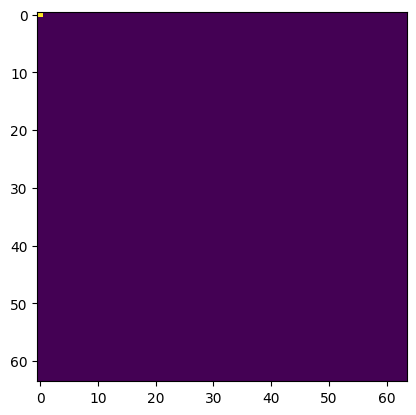

In [22]:
edges_upd = edges.at[:, non_diag_edge_idx.astype(jnp.int32).squeeze()].get()
receivers_upd = receivers.at[:, non_diag_edge_idx.astype(jnp.int32).squeeze()].get()
senders_upd = senders.at[:, non_diag_edge_idx.astype(jnp.int32).squeeze()].get()

plt.imshow(vmap(graph_to_low_tri_mat, in_axes=(0, 0, 0, 0), out_axes=(0))(nodes, edges_upd, receivers_upd, senders_upd)[0, ...])

In [ ]:
rng = np.random.default_rng(42)
a = rng.random(edges.shape)
# a[:, -1] = 0
# receivers = receivers.at[:, -1].set(0)
check_1 = vmap(graph_to_low_tri_mat_sparse, in_axes=(0, 0, 0, 0), out_axes=(0))(nodes, jnp.asarray(a), receivers, senders)
check_2 = vmap(graph_to_low_tri_mat, in_axes=(0, 0, 0, 0), out_axes=(0))(nodes, jnp.asarray(a), receivers, senders)

In [ ]:
jnp.allclose(check_1.todense(), check_2)

In [ ]:
plt.imshow(check_2[0, ...])

In [ ]:
A[0, ...]

In [ ]:
jsparse.coo_matmat(A[0, ...], b[0, ...])

In [ ]:
jnp.allclose(
    jsparse.bcoo_dot_general(A[None, 0, ...],b[None, 0, ...], dimension_numbers=((2, 1), (0, 0))),
    A[0, ...].todense() @ b[0, ...]
)

In [ ]:
jnp.allclose(jsparse.bcoo_transpose(A, permutation=[0, 2, 1]).todense(), jnp.transpose(A.todense(), axes=[0, 2, 1]))

In [ ]:
check_1.shape

In [ ]:
tril_i

In [ ]:
tril_i[0].shape

In [ ]:
check_2[0, tril_i[0], tril_i[0]].shape

In [ ]:
jnp.stack(triu_i).shape

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10, 10))

triu_i = jnp.triu_indices(check_2.shape[-1], k=1)

axes[0].imshow(check_2[0, ...])
abc = check_2 * triu_i[None, ...]
axes[1].imshow(abc[0, ...])

In [ ]:
(A.todense()[0, ...]).shape

In [ ]:
senders.shape

In [ ]:
nodes.shape

In [ ]:
check = jnp.nonzero(jnp.diff(jnp.hstack([senders[0, :, None], receivers[0, :, None]])), size=senders.shape[1]-nodes.shape[1], fill_value=jnp.nan)[0].astype(jnp.int32)
check_2 = jnp.where(jnp.diff(jnp.hstack([senders[0, :, None], receivers[0, :, None]])) == 0, 0, 1)
check_2 = jnp.squeeze(check_2).astype(bool)

In [ ]:
check, check_2

In [ ]:
check

In [ ]:
print(check.shape)
print(edges.shape)
print(edges[0, check].shape)
edges, edges[:, check]

In [ ]:
print(check_2.shape)
print(edges.shape)
print(edges[0, check_2].shape)
display(edges.shape, edges[0, check_2].shape)
jnp.allclose(edges[:, check], edges[:, check_2])

In [ ]:
A[0, ...].indices[:, 0]

In [ ]:
import numpy as np
def bi_direc_indx(receivers, senders, n_node):
    '''Returns indices of edges which corresponds to bi-direcional connetions.'''
    r_s = jnp.hstack([receivers[..., None], senders[..., None]])
    s_r = jnp.hstack([senders[..., None], receivers[..., None]])

    nrows, ncols = r_s.shape
    dtype={'names': ['f{}'.format(i) for i in range(ncols)], 'formats': ncols * [r_s.dtype]}
    _, comm1, comm2 = np.intersect1d(np.array(r_s).view(dtype), np.array(s_r).view(dtype), return_indices=True)
    
    bi_edge_pairs = jnp.hstack([comm1[..., None], comm2[..., None]])
    bi_edge_pairs = np.unique(bi_edge_pairs.sort(axis=1), axis=0)
    non_duplicated_nodes = np.nonzero(np.diff(bi_edge_pairs, axis=1))[0]
    bi_edge_pairs = bi_edge_pairs[non_duplicated_nodes]
    return bi_edge_pairs

In [ ]:
edges[0, ...].shape

In [ ]:
abc = bi_direc_indx(receivers[0, ...], senders[0, ...], nodes[1])

In [ ]:
A[0, :, :].data

In [ ]:
A[0, ...].data

In [ ]:
i = 0 # [0, 23]
for i in range(24):
    edges_new = edges[0, ...].at[abc[i, :]].set(20)
    ABC = jsparse.BCOO((edges_new, A[0, ...].indices), shape=A[0, ...].shape)
    plt.imshow(ABC.todense())
    plt.show()
    plt.clf();

In [ ]:
def bi_direc_edge_avg(edges, indices):
#     edges_upd = edges.copy()
#     for i in range(len(indices)):
#         edges_upd = edges_upd.at[indices[i]].set(jnp.mean(edges_upd[indices[i]]))
    b = len(edges)
    edges_new = edges[:, indices].mean(-1).reshape(b, -1, 1)
    edges_upd = edges.at[:, indices].set(edges_new)
    return edges_upd

In [ ]:
egdes_new = jnp.arange(edges[0, ...].shape[0]*3).reshape(3, 64) * 4.
# egdes_new = jnp.ones_like(edges[0, ...])[None, :] / 1.
egdes_new

In [ ]:
bi_direc_edge_avg(egdes_new, bi_edges[0, ...])

In [ ]:
f = egdes_new.shape[0]
bi_ind_local = bi_edges[0, ...]
edges_local = egdes_new
edges_upd = edges_local[:, bi_ind_local].mean(-1).reshape(f, -1, 1)
edges_upd = edges_local.at[:, bi_ind_local].set(edges_upd)

# edges_new.shape, edges_local[:, bi_ind_local].shape
# jnp.vstack([egdes_new, edges_upd])
egdes_new, edges_upd

In [ ]:
edges_upd

In [ ]:
egdes_new

In [ ]:
display(egdes_new[:, 1])
display(edges_upd[:, 1])

In [ ]:
for i in range(egdes_new.shape[-1]):
    print(egdes_new[:, i], edges_upd[:, i])

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(11, 11))

ABC_1 = jsparse.BCOO((egdes_new.squeeze()[0, ...], A[0, ...].indices), shape=A[0, ...].shape)
ABC_2 = jsparse.BCOO((edges_upd.squeeze()[0, ...], A[0, ...].indices), shape=A[0, ...].shape)

axes[0].imshow(ABC_1.todense())
axes[1].imshow(ABC_2.todense())
# plt.show()
# plt.clf();

In [ ]:
jnp.allclose(ABC_2.todense(), ABC_2.todense().T)

In [ ]:
nodes.shape

In [ ]:
L = jnp.zeros([nodes.shape[1]]*2)
L = L.at[senders, receivers].set(edges)

In [ ]:
A

In [ ]:
jnp.allclose(L, A[0, ...].todense())

In [ ]:
[1,2 ,3 ,4 , 5, 6][:-1]

In [ ]:
[2]*2

In [ ]:
23300 ** (1/2)